# Import packages

In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import shap
from pathlib import Path

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from matplotlib import rcParams
from cycler import cycler
from sklearn.inspection import permutation_importance
from statsmodels.stats.multitest import multipletests


rcParams.update({'figure.autolayout': True})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
linestyle_cycler =  [
     'solid','dotted', 'dashed','dashdot',
     (0, (1, 1)),(0, (1, 1))]
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'c', 'k']) 
                           + cycler('linestyle', linestyle_cycler)))

## Choose type of mode

In [87]:
#mode = 'positive'
mode = 'negative'
# mode = 'both'

Path(f'../results/{mode}').mkdir(exist_ok=True)

## Load lipid data

In [88]:
lipid_data_df = pd.read_csv(f'all_data_{mode}.csv')

In [89]:
lipid_data_df.isna().any().value_counts()

True     140
False    110
dtype: int64

In [90]:
print(lipid_data_df.isna().any().sort_values(ascending=False))

PS 18:2_18:2            True
LPC O-16:0              True
PC 16:0_17:0            True
PA 16:0_20:4            True
PC 16:0_20:1            True
PC 16:0_20:3            True
LPI 18:0 SN1            True
PC 16:0_22:5            True
LPC 22:4 SN1            True
PC 17:1_18:2            True
HexCer 18:1;2O/16:0     True
Cer d43:2               True
PC 17:0_22:6            True
SM d44:3                True
PC 18:0_20:3            True
PC 18:0_20:4            True
PC 16:0_20:4            True
PC 16:0_14:0            True
PC O-16:0_16:0          True
PA 16:0_18:2            True
LPE 22:6 SN1            True
LPE O-16:1              True
PC 20:4_20:4 Cis        True
LPI 18:0                True
LPI 20:4                True
PA 16:0_18:1            True
PC 14:0_14:0            True
PC 17:1_20:4            True
PC 14:0_16:0            True
PC 18:1_20:4            True
PC 14:0_20:4            True
PC 14:0_22:6            True
PC 18:1_18:2            True
PC 18:0_16:0            True
PC 18:1_16:0  

In [91]:
lipid_data_df

,Date,Blood Type,Person,Cer d18:1_16:0,Cer d18:1_18:0,Cer d18:1_18:1,Cer d18:1_20:0,Cer d18:1_22:0,Cer d18:1_24:0,Cer d18:1_24:1,Cer d18:2_16:0,Cer d40:2,Cer d41:1,Cer d41:2,Cer d43:1,Cer d44:1,Cer d44:2,CerP d18:1_16:0,Hex2Cer 32:1;2O,Hex2Cer 34:1;2O,Hex2Cer 34:2;2O,Hex2Cer 42:2;2O,Hex2Cer 42:3;2O,Hex3Cer 34:1;2O,HexCer 14:2;2O/28:0,HexCer 41:1;2O,HexCer 42:1;2O,LPC 14:0 SN2,LPC 14:0 SN1,LPC 15:0 SN2,LPC 15:0 SN1,LPC 16:0 SN1,LPC 16:0 SN2,LPC 16:1 SN1,LPC 16:1 SN2,LPC 17:0 SN2,LPC 17:0 SN1,LPC 18:0 SN1,LPC 18:1 SN1,LPC 18:1 SN2,LPC 18:2 SN1,LPC 18:2 SN2,LPC 18:3 SN1,LPC 19:0 SN1,LPC 20:0 SN1,LPC 20:1 SN1,LPC 20:2 SN1,LPC 20:3 SN1,LPC 20:4 SN1,LPC 20:4 SN2,LPC 20:5 SN1,LPC 22:0 SN1,LPC 22:5 SN1,LPC 22:6 SN2,LPC O-18:0,LPC O-18:1,LPC O-20:0,LPC O-22:0,LPC O-24:1,LPE 16:0 SN1,LPE 16:0 SN2,LPE 18:0 SN1,LPE 18:0 SN2,LPE 18:1 SN2,LPE 18:1 SN1,LPE 18:2 SN2,LPE 18:2 SN1,LPE 20:4 SN2,LPE 20:4 SN1,LPE 20:5 SN1,LPE 22:4 SN1,LPE 22:6 SN2,LPE 22:6 SN1,LPE O-16:1,LPE O-18:1,LPI 18:0,LPI 20:4,PA 16:0_18:1,PA 16:0_18:2,PC 14:0_14:0,PC 14:0_16:0,PC 14:0_18:2,PC 14:0_20:4,PC 14:0_22:6,PC 15:0_16:0,PC 15:0_18:2,PC 15:0_20:3,PC 15:0_20:4,PC 16:0_14:0,PC 16:0_16:0,PC 16:0_16:1,PC 16:0_18:1,PC 16:0_18:3,PC 16:0_20:1,PC 16:0_20:3,PC 16:0_20:5,PC 16:0_22:5,PC 16:0_22:6,PC 17:0_18:1,PC 17:0_18:2,PC 17:0_20:4,PC 17:0_22:6,PC 18:0_18:1,PC 18:0_20:1,PC 18:0_20:2,PC 18:0_20:3,PC 18:0_20:4,PC 18:0_22:6,PC 18:1_16:0,PC 18:1_22:6,PC 18:2_18:2 Cis,PC 18:2_20:4,PC 18:3_20:4,PC 19:0_18:2,PC 20:1_20:4,PC O-16:0_18:1,PC O-16:0_20:3,PC O-16:0_20:4,PC O-16:0_20:5,PC O-16:1_16:0,PC O-16:1_18:2,PC O-16:1_20:4,PC O-16:1_22:6,PC O-18:0_18:1,PC O-18:0_22:6,PC O-18:1_20:4,PC O-18:1_20:5,PC O-18:1_22:6,PC O-20:0_22:6,PC O-20:1_20:4,PC O-20:2_20:4,PC O-22:0_20:4,PC O-22:2_18:2,PC O-24:1_20:4,PE 16:0_16:0,PE 16:0_16:1,PE 16:0_18:1,PE 16:0_18:2,PE 16:0_20:4,PE 16:0_20:5,PE 16:0_22:6,PE 18:0_18:1,PE 18:0_20:4,PE 18:0_22:6,PE 18:1_18:1 Cis,PE 18:1_18:2,PE 18:2_18:2,PE 18:2_20:4,PE 18:3_18:3,PE O-16:1_20:4,PE O-16:1_22:6,PE O-17:1_20:4,PE O-17:1_22:6,PE O-18:1_18:1,PE O-18:1_20:4,PE O-18:1_22:6,PE O-18:2_22:6,PE O-20:0_18:2,PE O-20:1_18:2,PE O-20:1_20:4,PG 16:0_18:1,PG 16:0_18:2,PG 18:0_20:4,PG 18:1_18:1 Cis,PI 16:0_18:1,PI 16:0_18:2,PI 16:0_20:4,PI 16:0_22:5,PI 18:0_18:2,PI 18:0_20:3,PI 18:0_20:4,PI 18:0_22:4,PI 18:1_18:2,PS 16:0_16:0,PS 16:0_18:1,PS 18:0_18:0,PS 18:0_18:1,PS 18:0_18:2,PS 18:0_20:4,PS 18:0_22:6,SM 34:1;3O,SM 34:2;3O,SM d18:1_16:0,SM d18:1_18:0,SM d18:1_18:1,SM d18:1_24:0,SM d32:1,SM d32:2,SM d33:1,SM d34:0,SM d34:2,SM d35:1,SM d35:2,SM d38:1,SM d38:2,SM d39:1,SM d40:1,SM d40:2,SM d40:3,SM d41:1,SM d41:2,SM d41:3,SM d44:2,SM d44:3,Cer d43:2,HexCer 18:1;2O/16:0,LPC 22:4 SN1,LPC O-16:0,LPI 18:0 SN1,PA 16:0_20:4,PC 16:0_17:0,PC 16:0_20:4,PC 17:1_18:2,PC 17:1_20:4,PC 18:0_16:0,PC 18:1_18:2,PC 18:1_20:4,PC 20:4_20:4 Cis,PC O-16:0_16:0,PC O-18:0_22:4,PC O-18:1_16:0,PC O-22:0_18:2,PC O-22:1_20:4,PC O-22:1_22:6,PE O-16:1_18:1,PE O-16:1_22:4,PS 16:0_20:4,SM d18:1_24:1,SM d33:2,SM d36:3,LPC 18:0 SN2,LPC 19:0 SN2,PC 16:0_22:4,PC 18:0_20:5,PC 18:1_22:4,PC 18:2_20:5,PC 20:1_18:2,PC O-16:0_16:1,PE O-18:1_20:3,PE O-20:0_22:6,PI 16:0_16:1,PI 18:0_18:1,PI 18:1_20:4,PC 15:0_18:1,PC 16:0_12:0,PC 20:0_20:0,PC O-24:2_20:4,PE O-18:3_20:4,PI 18:0_22:5,PS 18:2_18:2
0,210625,Plasma,1,0.551140,0.273190,0.073787,0.892370,4.097725,12.651347,4.054020,0.041784,0.923236,5.212239,0.922044,1.296212,0.210177,0.070156,0.040447,0.194417,1.740990,0.000000,0.266635,0.055581,0.177616,0.788773,0.983307,2.667600,0.507340,2.957602,0.212720,1.518690,151.798818,11.927753,1.820881,0.301606,0.324331,1.912379,61.995327,41.073287,3.390462,57.797782,5.396382,0.157801,0.180300,0.222931,0.341067,0.219882,1.328803,10.363258,1.695924,0.849930,0.063994,0.400570,0.736395,0.459398,0.243025,0.073190,0.100175,0.151022,1.982092,0.277954,2.346494,0.283223,0.194390,2.685710,0.854510,5.393787,1.261617,3.740721,0.153212,0.037945,0.993351,2.186562,0.198792,0.285941,0.329163,0.365698,0.152777,0.087928,3.124296,0.035585,10.0

In [92]:
lipid_data_df.drop(columns=['Person', 'Date']).describe()

,Cer d18:1_16:0,Cer d18:1_18:0,Cer d18:1_18:1,Cer d18:1_20:0,Cer d18:1_22:0,Cer d18:1_24:0,Cer d18:1_24:1,Cer d18:2_16:0,Cer d40:2,Cer d41:1,Cer d41:2,Cer d43:1,Cer d44:1,Cer d44:2,CerP d18:1_16:0,Hex2Cer 32:1;2O,Hex2Cer 34:1;2O,Hex2Cer 34:2;2O,Hex2Cer 42:2;2O,Hex2Cer 42:3;2O,Hex3Cer 34:1;2O,HexCer 14:2;2O/28:0,HexCer 41:1;2O,HexCer 42:1;2O,LPC 14:0 SN2,LPC 14:0 SN1,LPC 15:0 SN2,LPC 15:0 SN1,LPC 16:0 SN1,LPC 16:0 SN2,LPC 16:1 SN1,LPC 16:1 SN2,LPC 17:0 SN2,LPC 17:0 SN1,LPC 18:0 SN1,LPC 18:1 SN1,LPC 18:1 SN2,LPC 18:2 SN1,LPC 18:2 SN2,LPC 18:3 SN1,LPC 19:0 SN1,LPC 20:0 SN1,LPC 20:1 SN1,LPC 20:2 SN1,LPC 20:3 SN1,LPC 20:4 SN1,LPC 20:4 SN2,LPC 20:5 SN1,LPC 22:0 SN1,LPC 22:5 SN1,LPC 22:6 SN2,LPC O-18:0,LPC O-18:1,LPC O-20:0,LPC O-22:0,LPC O-24:1,LPE 16:0 SN1,LPE 16:0 SN2,LPE 18:0 SN1,LPE 18:0 SN2,LPE 18:1 SN2,LPE 18:1 SN1,LPE 18:2 SN2,LPE 18:2 SN1,LPE 20:4 SN2,LPE 20:4 SN1,LPE 20:5 SN1,LPE 22:4 SN1,LPE 22:6 SN2,LPE 22:6 SN1,LPE O-16:1,LPE O-18:1,LPI 18:0,LPI 20:4,PA 16:0_18:1,PA 16:0_18:2,PC 14:0_14:0,PC 14:0_16:0,PC 14:0_18:2,PC 14:0_20:4,PC 14:0_22:6,PC 15:0_16:0,PC 15:0_18:2,PC 15:0_20:3,PC 15:0_20:4,PC 16:0_14:0,PC 16:0_16:0,PC 16:0_16:1,PC 16:0_18:1,PC 16:0_18:3,PC 16:0_20:1,PC 16:0_20:3,PC 16:0_20:5,PC 16:0_22:5,PC 16:0_22:6,PC 17:0_18:1,PC 17:0_18:2,PC 17:0_20:4,PC 17:0_22:6,PC 18:0_18:1,PC 18:0_20:1,PC 18:0_20:2,PC 18:0_20:3,PC 18:0_20:4,PC 18:0_22:6,PC 18:1_16:0,PC 18:1_22:6,PC 18:2_18:2 Cis,PC 18:2_20:4,PC 18:3_20:4,PC 19:0_18:2,PC 20:1_20:4,PC O-16:0_18:1,PC O-16:0_20:3,PC O-16:0_20:4,PC O-16:0_20:5,PC O-16:1_16:0,PC O-16:1_18:2,PC O-16:1_20:4,PC O-16:1_22:6,PC O-18:0_18:1,PC O-18:0_22:6,PC O-18:1_20:4,PC O-18:1_20:5,PC O-18:1_22:6,PC O-20:0_22:6,PC O-20:1_20:4,PC O-20:2_20:4,PC O-22:0_20:4,PC O-22:2_18:2,PC O-24:1_20:4,PE 16:0_16:0,PE 16:0_16:1,PE 16:0_18:1,PE 16:0_18:2,PE 16:0_20:4,PE 16:0_20:5,PE 16:0_22:6,PE 18:0_18:1,PE 18:0_20:4,PE 18:0_22:6,PE 18:1_18:1 Cis,PE 18:1_18:2,PE 18:2_18:2,PE 18:2_20:4,PE 18:3_18:3,PE O-16:1_20:4,PE O-16:1_22:6,PE O-17:1_20:4,PE O-17:1_22:6,PE O-18:1_18:1,PE O-18:1_20:4,PE O-18:1_22:6,PE O-18:2_22:6,PE O-20:0_18:2,PE O-20:1_18:2,PE O-20:1_20:4,PG 16:0_18:1,PG 16:0_18:2,PG 18:0_20:4,PG 18:1_18:1 Cis,PI 16:0_18:1,PI 16:0_18:2,PI 16:0_20:4,PI 16:0_22:5,PI 18:0_18:2,PI 18:0_20:3,PI 18:0_20:4,PI 18:0_22:4,PI 18:1_18:2,PS 16:0_16:0,PS 16:0_18:1,PS 18:0_18:0,PS 18:0_18:1,PS 18:0_18:2,PS 18:0_20:4,PS 18:0_22:6,SM 34:1;3O,SM 34:2;3O,SM d18:1_16:0,SM d18:1_18:0,SM d18:1_18:1,SM d18:1_24:0,SM d32:1,SM d32:2,SM d33:1,SM d34:0,SM d34:2,SM d35:1,SM d35:2,SM d38:1,SM d38:2,SM d39:1,SM d40:1,SM d40:2,SM d40:3,SM d41:1,SM d41:2,SM d41:3,SM d44:2,SM d44:3,Cer d43:2,HexCer 18:1;2O/16:0,LPC 22:4 SN1,LPC O-16:0,LPI 18:0 SN1,PA 16:0_20:4,PC 16:0_17:0,PC 16:0_20:4,PC 17:1_18:2,PC 17:1_20:4,PC 18:0_16:0,PC 18:1_18:2,PC 18:1_20:4,PC 20:4_20:4 Cis,PC O-16:0_16:0,PC O-18:0_22:4,PC O-18:1_16:0,PC O-22:0_18:2,PC O-22:1_20:4,PC O-22:1_22:6,PE O-16:1_18:1,PE O-16:1_22:4,PS 16:0_20:4,SM d18:1_24:1,SM d33:2,SM d36:3,LPC 18:0 SN2,LPC 19:0 SN2,PC 16:0_22:4,PC 18:0_20:5,PC 18:1_22:4,PC 18:2_20:5,PC 20:1_18:2,PC O-16:0_16:1,PE O-18:1_20:3,PE O-20:0_22:6,PI 16:0_16:1,PI 18:0_18:1,PI 18:1_20:4,PC 15:0_18:1,PC 16:0_12:0,PC 20:0_20:0,PC O-24:2_20:4,PE O-18:3_20:4,PI 18:0_22:5,PS 18:2_18:2
count,60.000000,15.000000,15.000000,60.000000,60.000000,60.000000,60.000000,15.000000,60.000000,60.000000,60.000000,60.000000,60.000000,45.000000,15.000000,60.000000,60.000000,30.000000,60.000000,60.000000,60.000000,60.000000,30.000000,30.000000,28.000000,56.000000,14.000000,56.000000,60.000000,60.000000,56.000000,42.000000,28.000000,42.000000,60.000000,59.000000,60.000000,60.000000,60.000000,56.000000,28.000000,56.000000,56.000000,42.000000,28.000000,60.000000,59.000000,56.000000,42.000000,42.000000,56.000000,42.000000,56.000000,14.000000,42.000000,56.000000,60.000000,60.000000,60.000000,42.000000,60.000000,45.000000,60.000000,60.000000,59.000000,57.000000,30.000000,60.000000,15.000000,57.000000,14.000000,60.000000,14.000000,14.000000,30.000000

# Remove lipids that does not appear in every person or type

In [93]:
lipid_data_df = lipid_data_df.drop(lipid_data_df[(lipid_data_df['Blood Type'] == 'Blood EDTA') &
                                             (lipid_data_df['Date'] == 210702)].index)
lipid_data_df = lipid_data_df.reset_index()
lipid_data_df_without_na = lipid_data_df.dropna(axis='columns')
plasma = lipid_data_df[lipid_data_df['Blood Type'] == 'Plasma'].dropna(axis='columns')
serum = lipid_data_df[lipid_data_df['Blood Type'] == 'Serum'].dropna(axis='columns')
blood_edta = lipid_data_df[lipid_data_df['Blood Type'] == 'Blood EDTA'].dropna(axis='columns')
dbs_venous = lipid_data_df[lipid_data_df['Blood Type'] == 'DBS - Venous'].dropna(axis='columns')
dbs_finger = lipid_data_df[lipid_data_df['Blood Type'] == 'DBS - Finger'].dropna(axis='columns')
blood_type_dict = {'Plasma': plasma, 
              'Serum':serum,
              'Blood EDTA': blood_edta,
              'DBS - Venous': dbs_venous,
              'DBS - Finger': dbs_finger}

In [94]:
dbs_venous

,index,Date,Blood Type,Person,Cer d18:1_16:0,Cer d18:1_20:0,Cer d18:1_22:0,Cer d18:1_24:0,Cer d18:1_24:1,Cer d40:2,Cer d41:1,Cer d41:2,Cer d43:1,Cer d44:1,Hex2Cer 32:1;2O,Hex2Cer 34:1;2O,Hex2Cer 42:2;2O,Hex2Cer 42:3;2O,Hex3Cer 34:1;2O,HexCer 14:2;2O/28:0,LPC 14:0 SN1,LPC 15:0 SN1,LPC 16:0 SN1,LPC 16:0 SN2,LPC 16:1 SN1,LPC 18:0 SN1,LPC 18:1 SN1,LPC 18:1 SN2,LPC 18:2 SN1,LPC 18:2 SN2,LPC 18:3 SN1,LPC 20:0 SN1,LPC 20:1 SN1,LPC 20:4 SN1,LPC 20:4 SN2,LPC 20:5 SN1,LPC 22:6 SN2,LPC O-18:1,LPC O-24:1,LPE 16:0 SN1,LPE 16:0 SN2,LPE 18:0 SN1,LPE 18:1 SN2,LPE 18:2 SN2,LPE 18:2 SN1,LPE 20:4 SN2,LPE 20:4 SN1,LPE 22:4 SN1,LPE 22:6 SN1,LPE O-18:1,PC 14:0_18:2,PC 15:0_18:2,PC 15:0_20:3,PC 15:0_20:4,PC 16:0_16:0,PC 16:0_16:1,PC 16:0_18:1,PC 16:0_18:3,PC 16:0_20:5,PC 16:0_22:6,PC 17:0_18:1,PC 17:0_18:2,PC 17:0_20:4,PC 18:0_18:1,PC 18:0_20:1,PC 18:0_20:2,PC 18:0_22:6,PC 18:1_22:6,PC 18:2_18:2 Cis,PC 18:2_20:4,PC O-16:0_20:5,PC O-16:1_16:0,PC O-16:1_18:2,PC O-16:1_20:4,PC O-18:0_22:6,PC O-18:1_20:4,PC O-18:1_22:6,PC O-24:1_20:4,PE 16:0_16:1,PE 16:0_18:2,PE 16:0_20:4,PE 16:0_20:5,PE 16:0_22:6,PE 18:0_18:1,PE 18:0_20:4,PE 18:0_22:6,PE 18:1_18:2,PE 18:2_20:4,PE O-16:1_20:4,PE O-16:1_22:6,PE O-17:1_20:4,PE O-17:1_22:6,PE O-18:1_18:1,PE O-18:1_20:4,PE O-18:2_22:6,PE O-20:0_18:2,PE O-20:1_20:4,PG 16:0_18:2,PI 16:0_18:1,PI 16:0_18:2,PI 16:0_20:4,PI 18:0_18:2,PI 18:0_20:3,PI 18:0_20:4,PI 18:1_18:2,PS 16:0_18:1,PS 18:0_18:1,PS 18:0_18:2,PS 18:0_22:6,SM 34:1;3O,SM 34:2;3O,SM d18:1_18:0,SM d18:1_18:1,SM d18:1_24:0,SM d32:1,SM d32:2,SM d33:1,SM d34:0,SM d34:2,SM d35:1,SM d35:2,SM d38:1,SM d38:2,SM d39:1,SM d40:1,SM d40:2,SM d40:3,SM d41:1,SM d41:2,SM d41:3,SM d44:2
3,3,210625,DBS - Venous,1,1.213672,0.457969,3.770875,6.554416,9.912868,0.587672,1.342682,0.280469,0.321981,0.223048,0.104072,1.973954,0.599390,0.056597,0.105465,0.683801,0.971290,0.647356,67.804247,6.722887,0.691477,26.654678,12.667536,1.626548,16.571568,2.355631,0.149465,0.150497,0.180289,3.782524,1.033990,0.269145,0.152759,0.275427,0.103220,1.419440,0.274416,1.958045,0.768522,0.581598,1.749711,2.691926,1.639557,0.620484,0.918301,1.005517,3.653371,2.021056,0.496071,0.503307,17.455892,7.560588,202.127077,4.250243,10.589673,38.329258,2.431665,4.423501,1.738161,46.435533,0.401810,1.444914,10.765991,1.444151,6.249618,2.395153,0.343956,0.863749,2.942479,3.023150,0.324360,3.126890,0.473631,0.384851,0.255343,6.124315,0.413680,0.630235,5.015353,7.139533,20.204235,1.615160,8.331634,1.023056,12.644474,3.623887,0.453167,0.101951,4.910963,51.068386,2.455372,0.151876,2.023429,0.101724,0.802002,0.688219,0.613501,1.863854,1.188075,13.387158,0.312034,0.994490,8.039492,3.205503,20.255614,0.257310,0.059884,13.811851,8.139874,53.722705,12.887698,0.538574,5.021677,2.965921,11.975893,1.334695,0.156035,9.464393,3.949960,2.680870,37.587436,13.449947,0.424210,7.378397,4.144175,0.335192,0.907703
7,8,210702,DBS - Venous,1,1.439258,0.550353,4.258637,8.984889,12.062282,0.726070,1.625201,0.330564,0.312672,0.310430,0.116208,2.306879,0.595846,0.069750,0.122305,0.360894,0.629386,0.428063,43.067011,4.511622,0.413974,22.186233,13.493296,2.022727,18.547769,2.848157,0.178658,0.169919,0.164914,2.051977,0.904100,0.251976,0.253277,0.215057,0.105500,1.537634,0.239789,1.686251,0.900168,0.648396,1.469289,2.539315,1.201239,0.597000,0.625033,1.091499,3.035348,2.436854,0.627423,0.472668,18.562440,5.388292,247.481950,5.562434,9.611910,28.853746,2.713686,5.103022,1.678137,67.766077,0.434387,2.117042,10.301316,1.180612,17.621949,3.903524,0.342760,0.910214,4.016396,3.985109,0.373436,3.099014,0.516387,0.407439,0.344048,9.173722,0.668809,0.874247,8.021480,10.507481,28.552200,2.159256,12.439274,1.579815,19.086271,5.002341,0.725618,0.177945,6.817253,72.948963,3.131779,0.222723,2.233617,0.085015,1.510957,1.117247,1.523876,2.957812,1.680518,20.693543,0.585798,1.371646,13.150887,5.145915,30.985022,0.264818,0.031430,15.677351,7.820398,66.068129,13.156266,0.516757,5.416224,3.277971,12.156324,1.483671,0.511259,9.822702,4.232230,2.908276,40.154240,14.35296

# Pair-wise scatter plots

In [95]:
# The parplot visualisation is not very helpful and takes a while to compute. Uncomment the next two lines 
# if it is needed.

#pairplot = sns.pairplot(lipid_data_df_without_na, y_vars=["Person", 'Blood Type', 'Date'], hue='Blood Type')
# pairplot.savefig(f'../results/{mode}/pair-plot.pdf')

# Dimension reduction

## PCA

In [96]:
Path(f'../results/{mode}/visualisation').mkdir(exist_ok=True)

In [97]:
pca = PCA(n_components=2)
lipid_data_df_without_na_standardised = (lipid_data_df_without_na.drop(
    columns=['Person', 'Blood Type', 'Date', 'index'])-
                            lipid_data_df_without_na.drop(
    columns=['Person', 'Blood Type', 'Date', 'index']).mean())/lipid_data_df_without_na.drop(
    columns=['Person', 'Blood Type', 'Date', 'index']).std()
projected_lipid_data = pca.fit_transform(lipid_data_df_without_na_standardised)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.41048055 0.20843758]
0.6189181327658936


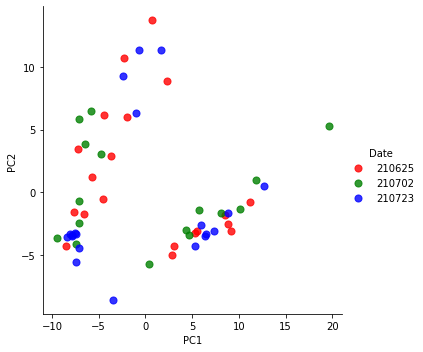

In [98]:
pc_df = pd.DataFrame(data = projected_lipid_data, columns = ['PC1', 'PC2'])
pc_df['Blood Type'] = lipid_data_df_without_na['Blood Type']
pc_df['Date'] = lipid_data_df_without_na['Date']

lmplot_persons = sns.lmplot(x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Date', # color by cluster
  legend=True,
  scatter_kws={"s": 50}) # specify the point size
lmplot_persons.savefig(f'../results/{mode}/visualisation/persons_pca.pdf')

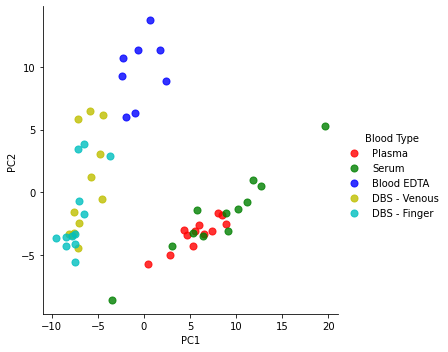

In [99]:
lmplot_type = sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Blood Type', # color by cluster
  legend=True,
  scatter_kws={"s": 50}) # specify the point size
lmplot_type.savefig(f'../results/{mode}/visualisation/type_pca.pdf')

## t-SNE

In [100]:
tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
projected_lipid_data = tsne.fit_transform(lipid_data_df_without_na_standardised)

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


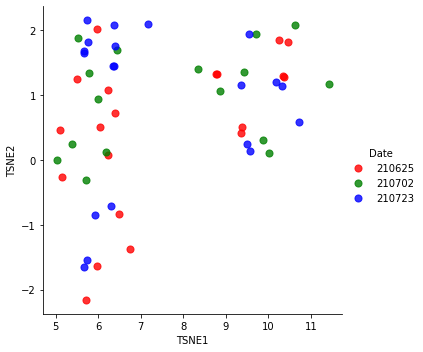

In [101]:
pc_df = pd.DataFrame(data = projected_lipid_data , 
        columns = ['TSNE1', 'TSNE2'])
pc_df['Blood Type'] = lipid_data_df_without_na['Blood Type']
pc_df['Date'] = lipid_data_df_without_na['Date']
lmplot_persons = sns.lmplot( x="TSNE1", y="TSNE2",
  data=pc_df, 
  fit_reg=False, 
  hue='Date', # color by cluster
  legend=True,
  scatter_kws={"s": 50}) # specify the point size
lmplot_persons.savefig(f'../results/{mode}/visualisation/persons_tsne.pdf')

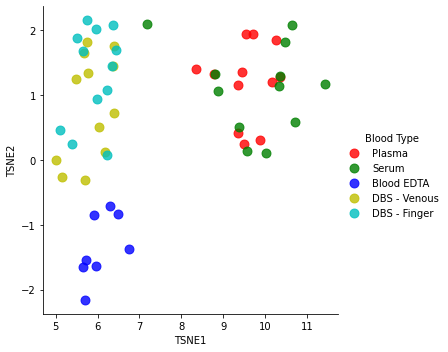

In [102]:
lmplot_type = sns.lmplot( x="TSNE1", y="TSNE2",
  data=pc_df, 
  fit_reg=False, 
  hue='Blood Type', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size
lmplot_type.savefig(f'../results/{mode}/visualisation/type_tsne.pdf')

# Statistical tests

In [103]:
p_border = 0.05
statistic_root_path = f'../results/{mode}/statistic/'
Path(statistic_root_path, 'friedman').mkdir(parents=True, exist_ok=True)
Path(statistic_root_path, 'kruskal-wallis').mkdir(parents=True, exist_ok=True)

## Friedman test to test differences in lipid distributions over timepoints per blood type

Exact p-value calculation does not work if there are ties. Switching to normal approximation.
Sample size too small for normal approximation.


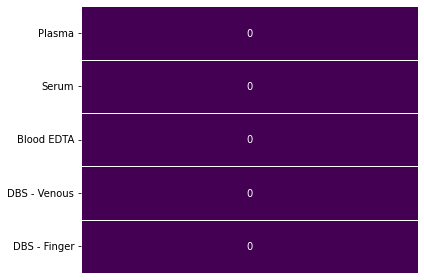

In [108]:
column = []
for key, value in blood_type_dict.items():
    p_value_list = list()
    lipid_counter = 0
    counter = 0
    dates = value['Date'].unique()
    if len(dates) == 3:
        first_date_data = value[value['Date'] == dates[0]]
        second_date_data = value[value['Date'] == dates[1]]
        third_date_data = value[value['Date'] == dates[2]]
        for k in value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys(): 
            lipid_counter += 1
            _, pvalue = stats.friedmanchisquare(first_date_data[k].dropna(), second_date_data[k].dropna(),
                                                third_date_data[k].dropna())
            p_value_list.append(pvalue)
        _, adjusted_p_values, _, _ = multipletests(p_value_list, method='fdr_bh')
        for adjusted_p_value in adjusted_p_values:
            if adjusted_p_value <= p_border:
                counter += 1
    else:
        first_date_data = value[value['Date'] == dates[0]]
        second_date_data = value[value['Date'] == dates[1]]
        for k in value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys(): 
            lipid_counter += 1
            _, pvalue = stats.wilcoxon(first_date_data[k].dropna(), second_date_data[k].dropna())   
            p_value_list.append(pvalue)
        _, adjusted_p_values, _, _ = multipletests(p_value_list, method='fdr_bh')
        for adjusted_p_value in adjusted_p_values:
            if adjusted_p_value <= p_border:
                counter += 1
    column.append(counter)

sns.heatmap(np.asarray(column)[:, np.newaxis],  linewidths=0.5, cmap='viridis',
            yticklabels=blood_type_dict.keys(), xticklabels=[], fmt='g', annot=True, cbar=False)
plt.savefig(f'{statistic_root_path}friedman/friedmann_test_blood_type.pdf')

# Compare intergroup differences

## Wilcoxon signed-rank test to test differences in lipid distribution between blood types. And visualise the number of differences with a heatmap.

In [105]:
Path(f'{statistic_root_path}wilcoxon').mkdir(parents=True, exist_ok=True)

Exact p-value calculation does not work if there are ties. Switching to normal approximation.
Sample size too small for normal approximation.


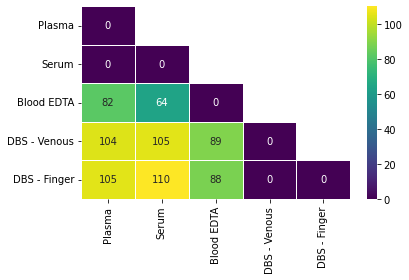

In [107]:
matrix = []
for first_key, first_value in blood_type_dict.items():
    column = []
    for second_key, second_value in blood_type_dict.items():
        
        counter = 0
        p_value_list = list()
        lipid_counter = 0
        if first_key != second_key:
            if len(first_value['Date'].unique()) == 2 or len(second_value['Date'].unique()) == 2:
                tmp_first_value = first_value.drop(first_value[first_value['Date'] == 210702].index)
                tmp_second_value = second_value.drop(second_value[second_value['Date'] == 210702].index)
                for k in first_value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys():
                    lipid_counter += 1
                    statistics, pvalue = stats.wilcoxon(tmp_first_value[k],
                                                        tmp_second_value[k], mode='exact')
                    p_value_list.append(pvalue)

            else:
                for k in first_value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys():
                    lipid_counter += 1
                    statistics, pvalue = stats.wilcoxon(first_value[k],
                                                        second_value[k], mode='exact')
                    p_value_list.append(pvalue)
            _, adjusted_p_values, _, _ = multipletests(p_value_list, method='fdr_bh')

            for adjusted_p_value in adjusted_p_values:
                if adjusted_p_value <= p_border:
                    counter += 1
        column.append(counter)
    matrix.append(column)

mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(matrix, annot=True, linewidths=0.5, cmap='viridis',
            xticklabels=blood_type_dict.keys(), yticklabels=blood_type_dict.keys(), fmt='g', mask=mask)
plt.savefig(f'{statistic_root_path}wilcoxon/wilcoxon_signed_rank_test.pdf')

## Generalized linear model

In [142]:
label_encoder = LabelEncoder()
blood_type = label_encoder.fit_transform(lipid_data_df_without_na['Blood Type'])

In [154]:
exog = pd.DataFrame({'Blood Type': blood_type})

In [155]:
data_endog

,Cer d18:1_16:0,Cer d18:1_20:0,Cer d18:1_22:0,Cer d18:1_24:0,Cer d18:1_24:1,Cer d40:2,Cer d41:1,Cer d41:2,Cer d43:1,Cer d44:1,Hex2Cer 32:1;2O,Hex2Cer 34:1;2O,Hex2Cer 42:2;2O,Hex2Cer 42:3;2O,Hex3Cer 34:1;2O,HexCer 14:2;2O/28:0,LPC 14:0 SN1,LPC 15:0 SN1,LPC 16:0 SN1,LPC 16:0 SN2,LPC 16:1 SN1,LPC 18:0 SN1,LPC 18:1 SN1,LPC 18:1 SN2,LPC 18:2 SN1,LPC 18:2 SN2,LPC 18:3 SN1,LPC 20:0 SN1,LPC 20:1 SN1,LPC 20:4 SN1,LPC 20:4 SN2,LPC 20:5 SN1,LPC 22:6 SN2,LPC O-18:1,LPC O-24:1,LPE 16:0 SN1,LPE 16:0 SN2,LPE 18:0 SN1,LPE 18:1 SN2,LPE 18:2 SN2,LPE 18:2 SN1,LPE 20:4 SN2,LPE 20:4 SN1,LPE 22:4 SN1,LPE 22:6 SN1,LPE O-18:1,PC 14:0_18:2,PC 15:0_18:2,PC 15:0_20:3,PC 15:0_20:4,PC 16:0_16:0,PC 16:0_16:1,PC 16:0_18:1,PC 16:0_18:3,PC 16:0_20:5,PC 16:0_22:6,PC 17:0_18:1,PC 17:0_18:2,PC 17:0_20:4,PC 18:0_18:1,PC 18:0_20:1,PC 18:0_20:2,PC 18:0_22:6,PC 18:1_22:6,PC 18:2_18:2 Cis,PC 18:2_20:4,PC O-16:0_20:5,PC O-16:1_16:0,PC O-16:1_18:2,PC O-16:1_20:4,PC O-18:0_22:6,PC O-18:1_20:4,PC O-18:1_22:6,PC O-24:1_20:4,PE 16:0_16:1,PE 16:0_18:2,PE 16:0_20:4,PE 16:0_20:5,PE 16:0_22:6,PE 18:0_18:1,PE 18:0_20:4,PE 18:0_22:6,PE 18:1_18:2,PE 18:2_20:4,PE O-16:1_20:4,PE O-16:1_22:6,PE O-17:1_20:4,PE O-17:1_22:6,PE O-18:1_18:1,PE O-18:1_20:4,PE O-18:2_22:6,PE O-20:0_18:2,PE O-20:1_20:4,PG 16:0_18:2,PI 16:0_18:1,PI 16:0_18:2,PI 16:0_20:4,PI 18:0_18:2,PI 18:0_20:3,PI 18:0_20:4,PI 18:1_18:2,PS 16:0_18:1,PS 18:0_18:1,PS 18:0_18:2,PS 18:0_22:6,SM 34:1;3O,SM 34:2;3O,SM d18:1_18:0,SM d18:1_18:1,SM d18:1_24:0,SM d32:1,SM d32:2,SM d33:1,SM d34:0,SM d34:2,SM d35:1,SM d35:2,SM d38:1,SM d38:2,SM d39:1,SM d40:1,SM d40:2,SM d40:3,SM d41:1,SM d41:2,SM d41:3,SM d44:2
0,0.551140,0.892370,4.097725,12.651347,4.054020,0.923236,5.212239,0.922044,1.296212,0.210177,0.194417,1.740990,0.266635,0.055581,0.177616,0.788773,2.957602,1.518690,151.798818,11.927753,1.820881,61.995327,41.073287,3.390462,57.797782,5.396382,0.157801,0.222931,0.341067,10.363258,1.695924,0.849930,0.736395,0.243025,0.151022,1.982092,0.277954,2.346494,0.194390,0.854510,5.393787,1.261617,3.740721,0.037945,2.186562,0.285941,10.092257,5.009858,1.208764,1.785421,16.375725,20.843470,419.050387,11.804277,37.637245,104.957213,4.150120,9.810715,5.103961,63.778503,0.531549,3.992461,40.888762,4.701844,19.745175,8.622920,0.356828,1.394432,6.792147,7.986498,0.946909,8.744425,1.636599,1.542939,0.056119,1.287122,0.070454,0.074501,1.786828,0.997527,7.314021,1.334895,0.782471,0.082576,4.511692,2.386728,0.207146,0.096917,0.561091,8.202084,1.176682,0.104218,0.516295,0.047613,1.489829,1.478537,2.342797,3.949100,2.204252,30.159130,0.568605,0.227851,0.208072,0.061645,0.166232,0.237708,0.054243,12.731787,6.288083,19.215337,12.071861,0.656461,4.254008,1.857020,16.180372,1.656281,0.171124,15.921911,4.458700,6.055887,33.964332,22.897050,0.438921,12.947757,7.535212,0.303588,0.099165
1,0.386617,0.692101,3.595647,10.420839,3.652670,0.776217,4.301123,0.778377,1.005571,0.149279,0.151909,1.410334,0.194020,0.052893,0.145097,0.804846,2.935077,1.493458,147.397409,13.571919,1.830957,68.325212,42.282443,3.505797,59.175511,6.263093,0.354232,0.205189,0.338131,10.683679,1.717210,0.837055,0.771026,0.458638,0.154767,2.038252,0.260672,2.549960,0.388825,0.793291,4.961188,1.020998,3.485777,0.083022,2.136718,0.125251,10.338736,5.830624,1.224422,1.736874,15.141325,20.642943,363.916210,10.809018,38.328671,120.523316,4.117424,10.452057,5.350983,69.489337,0.549915,4.157648,36.271175,4.642658,19.244937,8.915924,0.710152,1.331479,6.037609,7.464865,0.931207,8.868911,1.429527,1.689704,0.015695,1.357837,0.055400,0.080819,1.796868,0.853716,7.372851,1.437803,0.726434,0.080326,4.121172,2.197828,0.196008,0.094762,0.497435,7.515071,1.264569,0.085149,0.473696,0.037512,1.413437,1.479481,2.225387,3.419423,1.964469,27.808848,0.543935,0.000000,0.093348,0.014522,0.026474,0.206188,0.059773,11.767400,7.069348,18.660505,14.586158,0.650934,4.220765,1.881098,16.361101,1.474317,0.161030,15.054504,4.339992,5.567826,31.216769,25.535322,0.450750,13.584865,8.854931,0.319724,0.096343
2,1.961753,0.972315

In [162]:
import statsmodels.api as sm

data_endog = lipid_data_df_without_na.drop(
    columns=['Person', 'Blood Type', 'Date', 'index'])

#blood_type = sm.add_constant(blood_type, prepend=False)
glm_binom = sm.GLM(data_endog['Cer d18:1_16:0'], blood_type, 
                   family=sm.families.Gamma(sm.families.links.log()))
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Cer d18:1_16:0   No. Observations:                   56
Model:                            GLM   Df Residuals:                       55
Model Family:                   Gamma   Df Model:                            0
Link Function:                    log   Scale:                         0.28110
Method:                          IRLS   Log-Likelihood:                -23.028
Date:                Sun, 16 Jan 2022   Deviance:                       11.309
Time:                        20:30:12   Pearson chi2:                     15.5
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3444
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1569      0.028     -5.616      0.0

# Train a random forest classifier

In [22]:
classification_root_path = f'../results/{mode}/classification/'
Path(f'{classification_root_path}multiclass').mkdir(parents=True, exist_ok=True)
Path(f'{classification_root_path}one_vs_rest').mkdir(parents=True, exist_ok=True)
Path(f'{classification_root_path}one_vs_one').mkdir(parents=True, exist_ok=True)

In [324]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 3, 5]
min_samples_leaf = [1, 2, 4]
lw = 2
# Create the grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
random_forest = RandomForestClassifier()
num_classes = len(lipid_data_df_without_na['Blood Type'].unique())
lipid_x = lipid_data_df_without_na.drop(columns=['Person', 'Blood Type', 'Date'])
label_encoder = LabelEncoder()
blood_type = label_encoder.fit_transform(lipid_data_df_without_na['Blood Type'])
logo = LeaveOneGroupOut()

## Multiclass

In [525]:
all_true_multiclass = []
all_prediction_multiclass = []

auroc_list = []
outer_groups = lipid_data_df_without_na['Person']
list_shap_values_multiclass = list()
list_test_sets = list()
list_permutation_imortance = list()
for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
    train_val_data = lipid_x.iloc[train_index]
    test_data = lipid_x.iloc[test_index]
    blood_type_test_val = blood_type[train_index]
    blood_type_test = blood_type[test_index]
    inner_groups = outer_groups.iloc[train_index]
    grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                          cv = logo, n_jobs = -1, verbose = 1)
    clf = grid_search.fit(train_val_data,  blood_type_test_val, groups = inner_groups)
    
    #explaining model
    explainer = shap.TreeExplainer(clf.best_estimator_)
    shap_values = explainer.shap_values(test_data)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values_multiclass.append(shap_values)
    list_test_sets.append(test_index)
    importance = permutation_importance(clf, test_data, blood_type_test)
    list_permutation_imortance.append(importance)
    
    # test stuff
    y_pred_proba = clf.predict_proba(test_data)
    y_pred = clf.predict(test_data)
    all_true_multiclass.extend(blood_type_test)
    all_prediction_multiclass.extend(y_pred_proba)
tmp = [permutation_imortance.importances_mean for permutation_imortance in list_permutation_imortance]
mean_importance_multiclass = np.mean(tmp, axis=0)
tmp = [permutation_imortance.importances_std for permutation_imortance in list_permutation_imortance]
std_importance_multiclass = np.mean(tmp, axis=0)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits


## Permutation importance

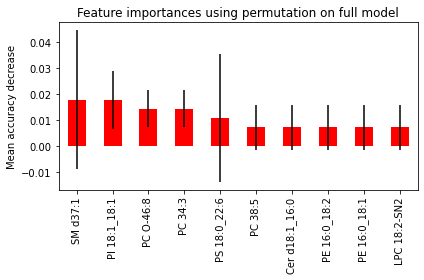

In [526]:
forest_importances = pd.Series(mean_importance_multiclass, index=lipid_x.keys())
forest_sd = pd.Series(std_importance_multiclass, index=lipid_x.keys())
both = pd.concat([forest_importances, forest_sd], axis=1).sort_values(by=0, ascending=False)

ax = both[0][:10].plot.bar(yerr=both[1])
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.savefig(f'{classification_root_path}multiclass/permutation_feature_importance_multiclass.pdf')

## Shap diagram

In [527]:
shap_values = np.concatenate(list_shap_values_multiclass, axis=1)
class_int = 0
for i in range(len(label_encoder.classes_)):
    shap.summary_plot(shap_values[i], lipid_x, show=False)
    plt.savefig(f'{classification_root_path}multiclass/\
multiclass_{label_encoder.inverse_transform([i])[0]}_shap_beeswarm.pdf')
    plt.clf()

<Figure size 576x684 with 0 Axes>

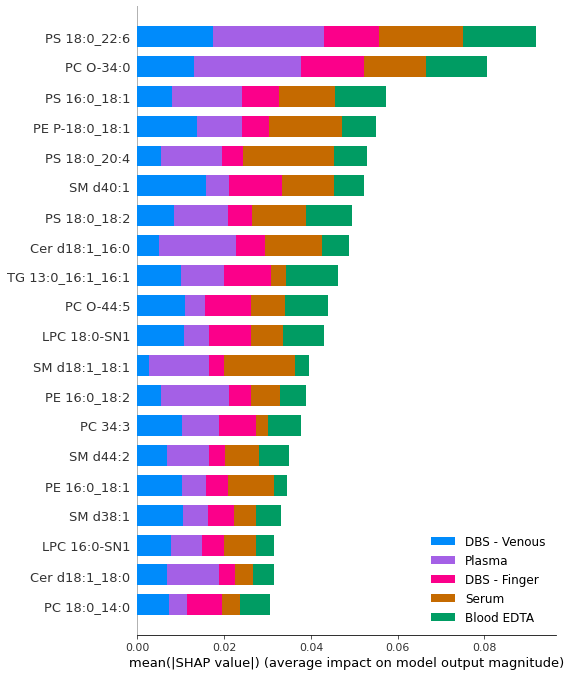

In [528]:
shap.summary_plot(list(shap_values[:,:,:]), lipid_x, plot_type="bar",
                  class_names=label_encoder.classes_, show=False)
plt.savefig(f'{classification_root_path}multiclass/multiclass_shap_bar.pdf')

## Visualise AUROC

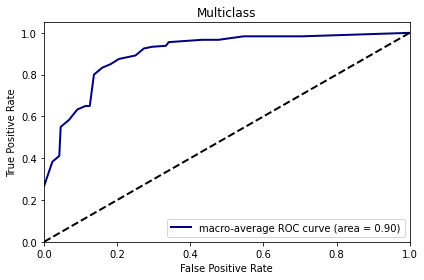

In [529]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    type_true = np.array([1 if y == i else 0 for y in all_true_multiclass])
    fpr[i], tpr[i], _ = roc_curve(type_true, np.array(all_prediction_multiclass)[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoder.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoder.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(label_encoder.classes_)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="-",
    linewidth=lw)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Multiclass')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig(f'{classification_root_path}multiclass/multiclass_classifier.pdf')
plt.show()

## One vs. rest classification

In [530]:
all_true_ovr = []
all_prediction_ovr = []

outer_groups = lipid_data_df_without_na['Person']
list_shap_values_ovr = list()
list_test_sets_ovr = list()
mean_importance_list_ovr = list()
std_importance_list_ovr = list()

for one_type in range(len(label_encoder.classes_)):
    all_true_type = []
    all_prediction_group = []
    tmp_list_shap_values = list()
    tmp_list_test_sets = list()
    list_permutation_imortance = list()
    for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
        ovr_blood_type = np.array([1 if y == one_type else 0 for y in blood_type])
        train_val_data = lipid_x.loc[train_index]
        test_data = lipid_x.loc[test_index]
        blood_type_test_val = ovr_blood_type[train_index]
        blood_type_test = ovr_blood_type[test_index]
        inner_groups = outer_groups.loc[train_index]
        grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                              cv = logo, n_jobs = -1, verbose = 1)
        clf = grid_search.fit(train_val_data, blood_type_test_val, groups = inner_groups)
        
        #explaining model
        explainer = shap.TreeExplainer(clf.best_estimator_)
        shap_values = explainer.shap_values(test_data)
        #for each iteration we save the test_set index and the shap_values
        tmp_list_shap_values.append(shap_values)
        tmp_list_test_sets.append(test_index)
        importance = permutation_importance(clf, test_data, blood_type_test)
        list_permutation_imortance.append(importance)
    
        # test stuff
        y_pred_proba = clf.predict_proba(test_data)
        y_pred = clf.predict(test_data)
        all_true_type.extend(blood_type_test)
        all_prediction_group.extend(y_pred_proba)
    
    list_shap_values_ovr.append(np.concatenate(tmp_list_shap_values,axis=1))
    list_test_sets_ovr.append(np.concatenate(tmp_list_test_sets, axis = 0))
    all_true_ovr.append(all_true_type)
    all_prediction_ovr.append(all_prediction_group)
    tmp = [permutation_imortance.importances_mean for permutation_imortance in list_permutation_imortance]
    mean_importance = np.mean(tmp, axis=0)
    tmp = [permutation_imortance.importances_std for permutation_imortance in list_permutation_imortance]
    std_importance = np.mean(tmp, axis=0)
    mean_importance_list_ovr.append(mean_importance)
    std_importance_list_ovr.append(std_importance)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 8

## Permutation importance

In [531]:
for i in range(len(label_encoder.classes_)):
    mean_importance = mean_importance_list_ovr[i]
    std_importance = std_importance_list_ovr[i]
    forest_importances = pd.Series(mean_importance, index=lipid_x.keys())
    forest_sd = pd.Series(std_importance, index=lipid_x.keys())
    both = pd. concat([forest_importances, forest_sd], axis=1).sort_values(by=0, ascending=False)

    fig, ax = plt.subplots()
    both[0][:10].plot.bar(yerr=both[1], ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    plt.savefig(f'{classification_root_path}one_vs_rest/\
{label_encoder.inverse_transform([i])[0]}_vs_rest_permutation_importance.pdf')
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## SHAP

In [532]:
for i in range(len(label_encoder.classes_)):
    shap_values = list_shap_values_ovr[i]
    test_set = list_test_sets_ovr[i]
    X = X_test = lipid_x.loc[test_set]
    shap.summary_plot(shap_values[1], X, show=False, max_display=10)
    plt.savefig(f'{classification_root_path}/one_vs_rest/{label_encoder.inverse_transform([i])[0]}\
    _vs_rest_shap_beeswarm.pdf')
    plt.clf()
    shap.summary_plot(list(shap_values[:,:,:]), X, plot_type="bar",
                  class_names=[label_encoder.inverse_transform([i])[0], 'Others'], show=False)
    plt.savefig(f'{classification_root_path}one_vs_rest/{label_encoder.inverse_transform([i])[0]}\
_vs_rest_shap_bar.pdf')
    plt.clf()

<Figure size 576x684 with 0 Axes>

## Visualise AUROC

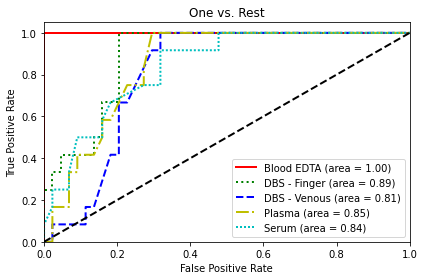

In [533]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(all_true_ovr[i], np.array(all_prediction_ovr[i])[:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], lw=lw,
        label=f"{label_encoder.inverse_transform([i])[0]} (area = {roc_auc[i]:0.2f})")


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoder.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoder.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(label_encoder.classes_)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('One vs. Rest')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig(f'{classification_root_path}one_vs_rest/one_vs_rest_classifier.pdf')
plt.show()

## One vs. one classification

In [534]:
all_true_ovo_list = []
all_prediction_ovo_list = []


for one_type in range(len(label_encoder.classes_)):
    all_true_type = []
    all_prediction_type = []

    for second_one_type in range(len(label_encoder.classes_)):
        if one_type == second_one_type:
            all_true_type.append([])
            all_prediction_type.append([])
            continue
        d = {one_type: 1, second_one_type: 0}
        ovo_blood_type = np.array([d[y]  for y in blood_type if y in d])
        indices = np.nonzero(np.isin(blood_type, [one_type, second_one_type]))
        outer_groups = lipid_data_df_without_na.loc[indices[0]]['Person']
        lipid_x = lipid_data_df_without_na.loc[indices[0]].drop(columns=['Person', 'Blood Type', 'Date'])
        all_prediction_ovo = []
        all_true_ovo = []
        for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
            train_val_data = lipid_x.iloc[train_index]
            test_data = lipid_x.iloc[test_index]
            blood_type_test_val = ovo_blood_type[train_index]
            blood_type_test = ovo_blood_type[test_index]
            inner_groups = outer_groups.iloc[train_index]
            grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                                  cv = logo, n_jobs = -1, verbose = 1)
            clf = grid_search.fit(train_val_data, blood_type_test_val, groups = inner_groups)

        
            # test stuff
            y_pred_proba = clf.predict_proba(test_data)
            y_pred = clf.predict(test_data)
            all_true_ovo.extend(blood_type_test)
            all_prediction_ovo.extend(y_pred_proba)
        all_true_type.append(all_true_ovo)
        all_prediction_type.append(all_prediction_ovo)
    all_true_ovo_list.append(all_true_type)
    all_prediction_ovo_list.append(all_prediction_type)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 8

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/tony/.virtualenvs/lipid-study/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 575, in run
    self.flag_executor_shutting_down()
  File "/home/tony/.virtualenvs/lipid-study/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 770, in flag_executor_shutting_down
    self.kill_workers(reason="executor shutting down")
  File "/home/tony/.virtualenvs/lipid-study/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 781, in kill_workers
    recursive_terminate(p)
  File "/home/tony/.virtualenvs/lipid-study/lib/python3.9/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/tony/.virtualenvs/lipid-study/lib/python3.9/site-packages/joblib/externals

KeyboardInterrupt: 

## Visualise AUROCS

In [ ]:
for one_type in range(len(label_encoder.classes_)):
    for second_one_type in range(len(label_encoder.classes_)):
        if one_type == second_one_type:
            continue
        all_true_ovo = all_true_ovo_list[one_type][second_one_type]
        all_prediction_ovo = all_prediction_ovo_list[one_type][second_one_type]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        lw = 2


        fpr, tpr, _ = roc_curve(all_true_ovo, np.array(all_prediction_ovo)[:,1])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=lw,
            label=f"{label_encoder.inverse_transform([one_type])[0]}"\
                 f" vs. {label_encoder.inverse_transform([second_one_type])[0]} (area = {roc_auc:0.2f})")

        plt.plot([0, 1], [0, 1], "k--", lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f'{label_encoder.inverse_transform([one_type])[0]} vs. One')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
    plt.savefig(f'{classification_root_path}one_vs_one/\
{label_encoder.inverse_transform([one_type])[0]}_vs_one_classifier.pdf')
    plt.show()